In [1]:
# Importing essential libraries.
from data_imports import *
from data_clean import data, time_based

In [138]:
# Importing machine-learning libraries.
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import shap

In [183]:
clean_df = data()
time_df = time_based(data())
#display(time_df)

In [125]:
lag_df = data()
lag_df['ozone_lag'] = lag_df['O3_ppbV'].shift(1)

In [196]:
def HGBR_shap(input_data, var, top_n):
    # Seperating the dataframes based on missing O3 values and assinging to variables.
    df_missing = input_data[input_data[var].isnull()]
    df_not_missing = input_data.dropna(subset = [var])

    # Seperating features and target variable.
    X = df_not_missing.drop(columns = [var])
    y = df_not_missing[var]
    
    # Splitting the data into train and testing subsets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Training the model.
    clf = HistGradientBoostingRegressor(random_state = 1)    
    
    clf.fit(X_train, y_train)
    
    explainer = shap.Explainer(clf)
    shap_values = explainer.shap_values(X_test)
        
    shap_importance = np.abs(shap_values).mean(axis=0)
    top_n_indices = np.argsort(shap_importance)[-top_n:][::-1]  # Indices of the top 10 features
    top_n_features = X.columns[top_n_indices]
    return input_data[top_n_features.to_list() + [var]]

In [203]:
def HGBR(input_data, var, shap_i, state):
    # Seperating the dataframes based on missing O3 values and assinging to variables.
    df_missing = input_data[input_data[var].isnull()]
    df_not_missing = input_data.dropna(subset = [var])

    # Seperating features and target variable.
    X = df_not_missing.drop(columns = [var])
    y = df_not_missing[var]
    
    # Splitting the data into train and testing subsets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
    
    # Training the model.
    clf = HistGradientBoostingRegressor(random_state = 1)    
    
    clf.fit(X_train, y_train)

    # Predictions on the training set.
    y_train_pred = clf.predict(X_train)

    # Predictions on the test set.
    y_test_pred = clf.predict(X_test)
    
    if shap_i == True:
        explainer = shap.Explainer(clf)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test)
    
    # Calculating regression metrics for the training set.
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = mse_train ** 0.5
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculating regression metrics for the test set.
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = mse_test ** 0.5
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    if state == True:
        # Print training set regression metrics.
        print(f'Training Set - MSE: {mse_train:8.5f}, RMSE: {rmse_train:8.5f}, MAE: {mae_train:8.5f}, R2: {r2_train:8.5f}')

        # Print test set regression metrics.
        print(f'Testing Set  - MSE: {mse_test:8.5f}, RMSE: {rmse_test:8.5f}, MAE: {mae_test:8.5f}, R2: {r2_test:8.5f}')
    else:
        return [[mse_train, rmse_train, mae_train, r2_train], [mse_test, rmse_test, mae_test, r2_test]]

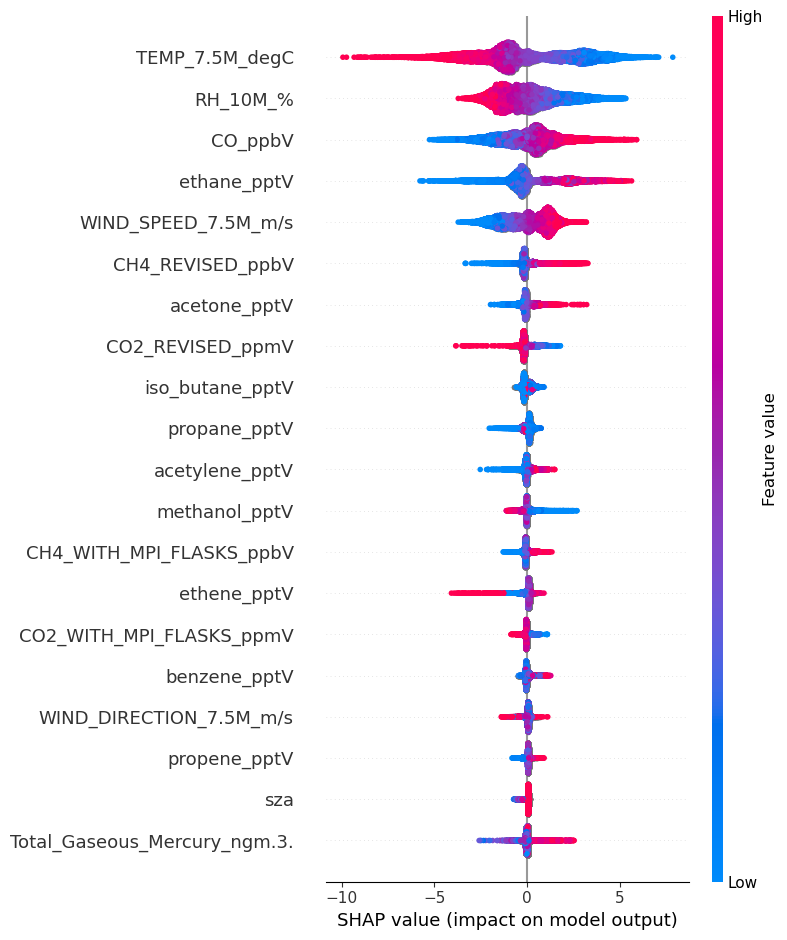

[[11.549450497509632,
  3.398448248467178,
  2.590459361078014,
  0.7880348573913822],
 [12.02466727469259, 3.46766020173439, 2.6549757855609784, 0.7795779725585423]]

In [219]:
HGBR(clean_df, 'O3_ppbV', True, False)

In [199]:
shap_var_df = HGBR_shap(clean_df, 'O3_ppbV', 15)
HGBR(shap_var_df, 'O3_ppbV', False, False)

Training Set - MSE: 12.64969, RMSE:  3.55664, MAE:  2.70937, R2:  0.76784
Testing Set  - MSE: 13.07726, RMSE:  3.61625, MAE:  2.77551, R2:  0.76028


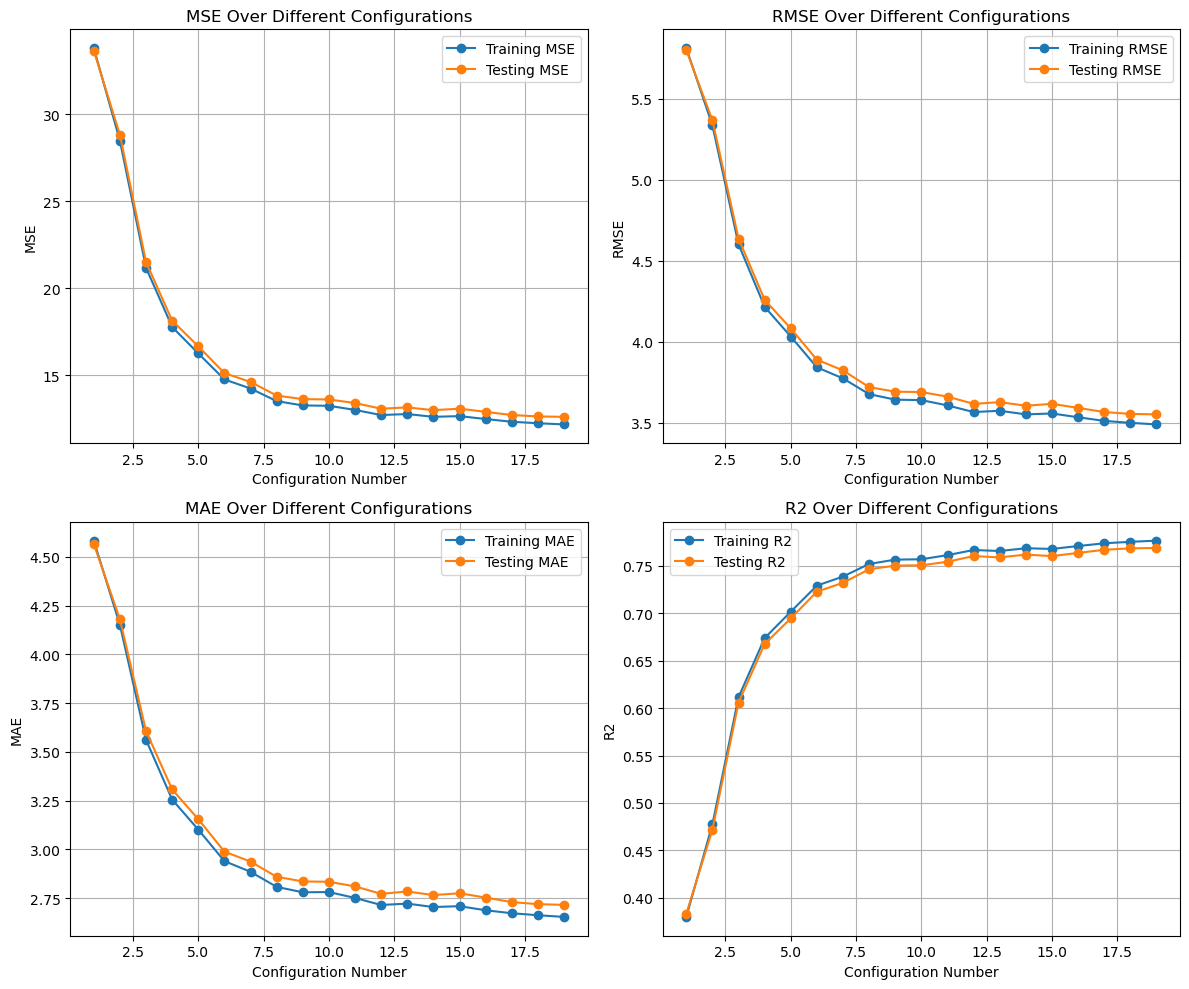

In [218]:
def importance(features):

    feature_range = range(1, features)

    MSE = [[], []]
    RMSE = [[], []]
    MAE = [[], []]
    R2 = [[], []]

    metrics = [MSE, RMSE, MAE, R2]
    metric_names = ['MSE', 'RMSE', 'MAE', 'R2']

    for n in feature_range:

        shap_var_df = HGBR_shap(clean_df, 'O3_ppbV', n)
        HGBR_m = HGBR(shap_var_df, 'O3_ppbV', False, False)
        MSE[0].append(HGBR_m[0][0])
        MSE[1].append(HGBR_m[1][0])
        RMSE[0].append(HGBR_m[0][1])
        RMSE[1].append(HGBR_m[1][1])
        MAE[0].append(HGBR_m[0][2])
        MAE[1].append(HGBR_m[1][2])
        R2[0].append(HGBR_m[0][3])
        R2[1].append(HGBR_m[1][3])

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs = axs.flatten()

    for i, metric in enumerate(metrics):
        axs[i].plot(feature_range, metric[0], marker='o', label=f'Training {metric_names[i]}')
        axs[i].plot(feature_range, metric[1], marker='o', label=f'Testing {metric_names[i]}')
        axs[i].set_title(f'{metric_names[i]} Over Different Configurations')
        axs[i].set_xlabel('Configuration Number')
        axs[i].set_ylabel(metric_names[i])
        axs[i].legend()
        axs[i].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

importance(20)

In [170]:
HGBR(lag_df, 'O3_ppbV', False)

Training Set - MSE:  0.63190, RMSE:  0.79492, MAE:  0.51959, R2:  0.98840
Testing Set  - MSE:  0.74566, RMSE:  0.86351, MAE:  0.53216, R2:  0.98633


In [134]:
HGBR(time_df, 'O3_ppbV', True)

Training Set - MSE:  9.81079, RMSE:  3.13222, MAE:  2.41302, R2:  0.81994
Testing Set  - MSE: 10.33440, RMSE:  3.21472, MAE:  2.47751, R2:  0.81056


In [101]:
range_O3 = time_df['O3_ppbV'].max() - time_df['O3_ppbV'].min()
print(range_O3)
print(time_df['O3_ppbV'].max())
print(time_df['O3_ppbV'].min())
print(time_df['O3_ppbV'].mean())

51.0
58.2
7.2
32.86906356704848


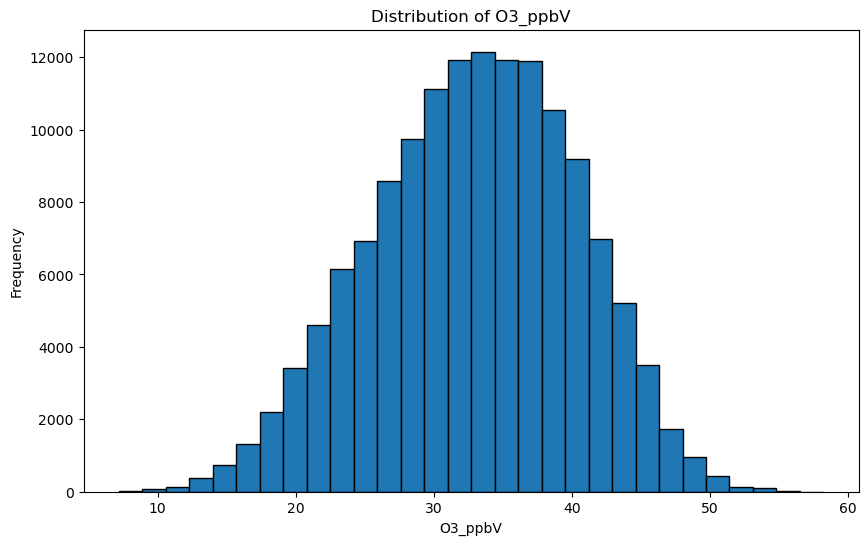

In [69]:
plt.figure(figsize=(10, 6))  
plt.hist(time_df['O3_ppbV'], bins=30, edgecolor='black')

plt.title('Distribution of O3_ppbV')
plt.xlabel('O3_ppbV')
plt.ylabel('Frequency')

plt.show()